# Actividades de aplicación GBM

 ## Aplicación 1
 


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

# 1. Configuración y descarga de datos
stocks = ["AAPL", "MSFT", "NVDA", "AMZN"]
end = dt.datetime.now()
start = end - dt.timedelta(days=365*3)
prices = yf.download(stocks, start=start, end=end, progress=False)["Close"]
returns = prices.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

In [10]:
# 2. Parámetros de la simulación
num_portfolios = 50 
num_sim = 10000 
num_days = 252
k = len(stocks)

results = []
all_sims = []
# Factorización de Cholesky para retornos correlacionados
L = np.linalg.cholesky(cov_matrix)

In [11]:
# 3. Ciclo para generar combinaciones de pesos
for i in range(num_portfolios):
    # Generar pesos aleatorios que sumen 1
    w = np.random.random(k)
    w /= np.sum(w)
    
    # Simulación de Monte Carlo vectorizada para mayor velocidad
    Z = np.random.normal(size=(num_days, num_sim, k))
    # Correlacionar ruidos: Z @ L.T
    correlated_returns = np.einsum('ijk,lk->ijl', Z, L) 
    daily_returns = correlated_returns + mean_returns.values
    
    # Retornos del portafolio (Ponderación de activos)
    port_daily_returns = np.dot(daily_returns, w)
    
    # Retorno final acumulado de cada simulación
    final_returns = np.prod(1 + port_daily_returns, axis=0) - 1
    
    # Métricas
    m_ret = np.mean(final_returns)
    m_std = np.std(final_returns)
    var_95 = np.percentile(final_returns, 5) # Percentil 5 para VaR 95%
    
    results.append({
        'weights': w,
        'retorno': m_ret,
        'stdev': m_std,
        'VaR_95': var_95
    })
    all_sims.append(final_returns)

df_results = pd.DataFrame(results)

In [12]:
# 4. Aplicar restricción: VaR 95% >= -5% (-0.05)
cumplen = df_results[df_results['VaR_95'] >= -0.05]
no_cumplen = df_results[df_results['VaR_95'] < -0.05]

# Identificar el mejor portafolio que cumple la restricción
if not cumplen.empty:
    mejor_portafolio = cumplen.loc[cumplen['retorno'].idxmax()]
    idx_mejor = cumplen['retorno'].idxmax()
else:
    mejor_portafolio = None
    print("Ningún portafolio cumplió la restricción del VaR.")

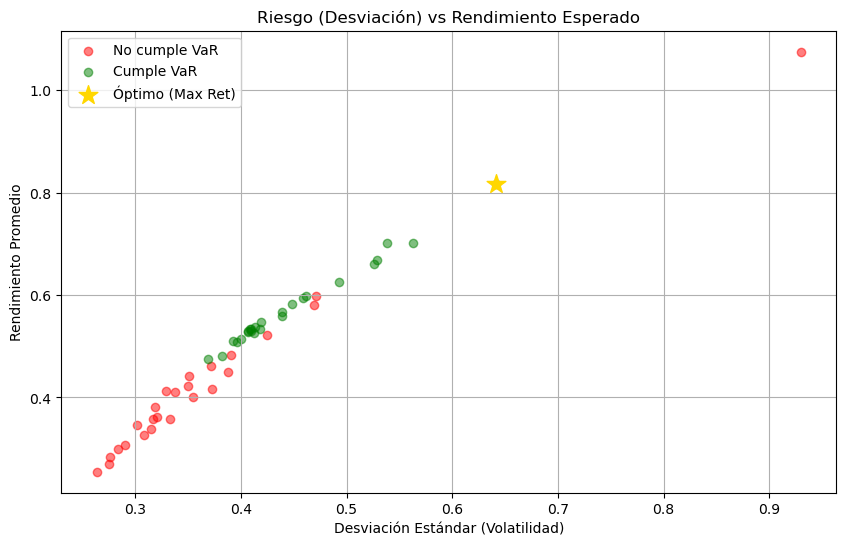

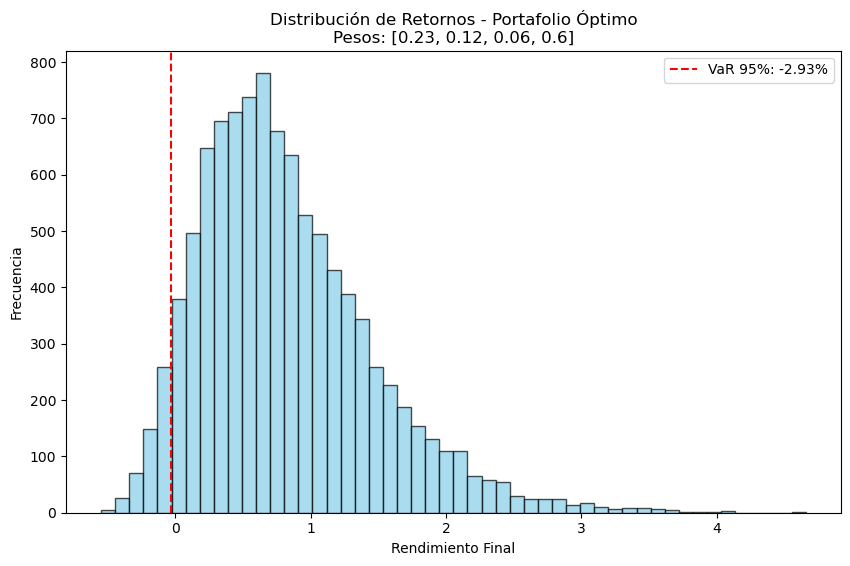


--- RESULTADOS ---
1. Portafolios que cumplen la restricción: 25 de 50
2. Rendimiento del mejor portafolio que cumple: 81.63%
3. Rendimiento sacrificado por control de riesgo: 25.91%


In [13]:

# --- VISUALIZACIÓN ---

# A. Scatter Plot Riesgo vs Rendimiento
plt.figure(figsize=(10, 6))
plt.scatter(no_cumplen['stdev'], no_cumplen['retorno'], c='red', alpha=0.5, label='No cumple VaR')
plt.scatter(cumplen['stdev'], cumplen['retorno'], c='green', alpha=0.5, label='Cumple VaR')
if mejor_portafolio is not None:
    plt.scatter(mejor_portafolio['stdev'], mejor_portafolio['retorno'], c='gold', marker='*', s=200, label='Óptimo (Max Ret)')
plt.title("Riesgo (Desviación) vs Rendimiento Esperado")
plt.xlabel("Desviación Estándar (Volatilidad)")
plt.ylabel("Rendimiento Promedio")
plt.legend()
plt.grid(True)
plt.show()

# B. Histograma del Portafolio Elegido
if mejor_portafolio is not None:
    plt.figure(figsize=(10, 6))
    plt.hist(all_sims[idx_mejor], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(mejor_portafolio['VaR_95'], color='red', linestyle='--', label=f'VaR 95%: {mejor_portafolio["VaR_95"]:.2%}')
    plt.title(f"Distribución de Retornos - Portafolio Óptimo\nPesos: {list(np.round(mejor_portafolio['weights'],2))}")
    plt.xlabel("Rendimiento Final")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()

# Respuestas
print(f"\n--- RESULTADOS ---")
print(f"1. Portafolios que cumplen la restricción: {len(cumplen)} de {num_portfolios}")
if mejor_portafolio is not None:
    max_global = df_results['retorno'].max()
    sacrificio = max_global - mejor_portafolio['retorno']
    print(f"2. Rendimiento del mejor portafolio que cumple: {mejor_portafolio['retorno']:.2%}")
    print(f"3. Rendimiento sacrificado por control de riesgo: {sacrificio:.2%}")

## Aplicación 2

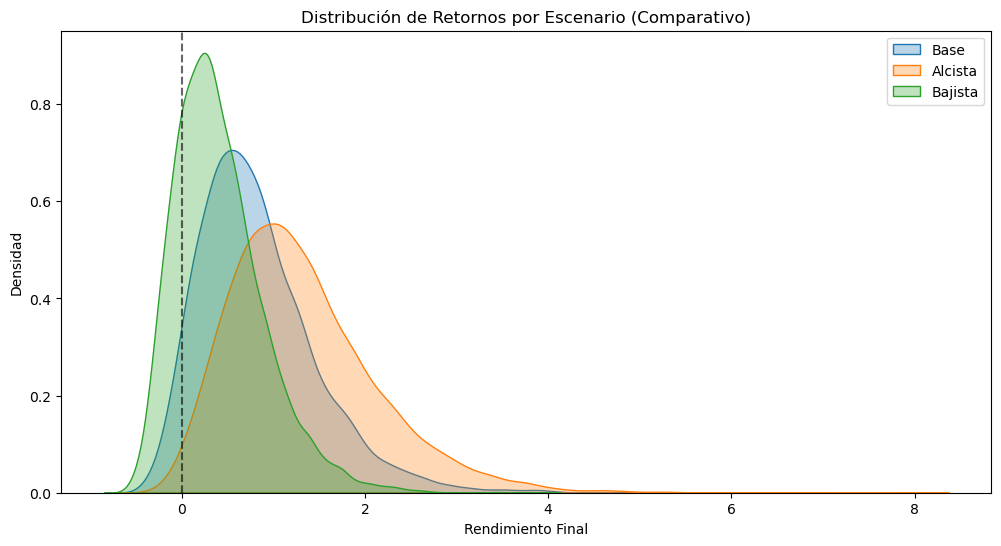

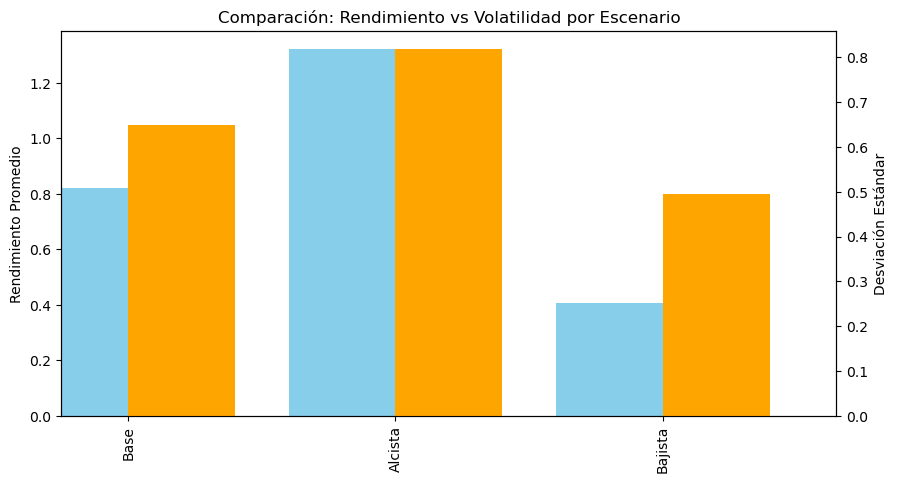

         Rendimiento Promedio  Desviación Estándar  Prob. Pérdida   VaR 95%
Base                 0.820667             0.648928         0.0571 -0.020682
Alcista              1.321319             0.817711         0.0107  0.238807
Bajista              0.408131             0.494418         0.2048 -0.250219


In [14]:
# 1. Definición de escenarios sobre el portafolio óptimo
# Usamos los pesos del mejor portafolio identificado anteriormente
w_opt = mejor_portafolio['weights']
mu_base = mean_returns.values
vol_matrix = L # Matriz de Cholesky ya calculada

escenarios = {
    "Base": mu_base,
    "Alcista": mu_base + 0.001,
    "Bajista": mu_base - 0.001
}

res_escenarios = {}
sims_por_escenario = {}

# 2. Simulación de 10,000 trayectorias por escenario
for nombre, mu in escenarios.items():
    Z = np.random.normal(size=(num_days, 10000, k))
    correlated = np.einsum('ijk,lk->ijl', Z, vol_matrix)
    daily_ret = correlated + mu
    
    # Retorno del portafolio y resultado final acumulado
    port_daily = np.dot(daily_ret, w_opt)
    final_returns = np.prod(1 + port_daily, axis=0) - 1
    
    # Cálculos de métricas
    res_escenarios[nombre] = {
        "Rendimiento Promedio": np.mean(final_returns),
        "Desviación Estándar": np.std(final_returns),
        "Prob. Pérdida": np.mean(final_returns < 0),
        "VaR 95%": np.percentile(final_returns, 5)
    }
    sims_por_escenario[nombre] = final_returns

df_escenarios = pd.DataFrame(res_escenarios).T

# 3. VISUALIZACIÓN
# A. Histogramas comparativos
plt.figure(figsize=(12, 6))
for nombre, data in sims_por_escenario.items():
    sns.kdeplot(data, label=nombre, fill=True, alpha=0.3)
plt.axvline(0, color='black', linestyle='--', alpha=0.6)
plt.title("Distribución de Retornos por Escenario (Comparativo)")
plt.xlabel("Rendimiento Final")
plt.ylabel("Densidad")
plt.legend()
plt.show()

# B. Gráfico comparativo de Medias y Desviaciones
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

df_escenarios["Rendimiento Promedio"].plot(kind='bar', ax=ax1, color='skyblue', position=1, width=0.4, label='Rendimiento')
df_escenarios["Desviación Estándar"].plot(kind='bar', ax=ax2, color='orange', position=0, width=0.4, label='Desviación')

ax1.set_ylabel("Rendimiento Promedio")
ax2.set_ylabel("Desviación Estándar")
plt.title("Comparación: Rendimiento vs Volatilidad por Escenario")
plt.show()

print(df_escenarios)